In [25]:
import numpy as np
import pandas as pd
import simpy
import matplotlib.pyplot as plt
import itertools

simpy.__version__

'3.0.12'

In [3]:
seeds = [199769, 778141, 120488, 523288, 447677, 586533, 309253, 332099,
         134200, 218660, 137802, 431191, 709036, 113578, 901009, 662765,
         877876, 952621, 514789, 118072]

In [4]:
capacity = pd.read_csv('data/shifts.csv')
capacity

,dow,clinic_1,clinic_2,clinic_3,clinic_4,clinic_5,clinic_6,clinic_7,clinic_8,clinic_9,clinic_10,clinic_11
0,Mon,4,1,7,3,1,5,3,3,5,11,1
1,Tue,4,1,6,3,1,5,3,3,5,10,0
2,Wed,4,1,7,3,2,5,4,3,5,11,1
3,Thu,4,1,6,3,1,5,3,3,5,10,1
4,Fri,4,1,6,2,1,4,3,2,4,10,0


In [7]:
ANNUAL_DEMAND = 16328
LOW_PRIORITY_MIN_WAIT = 3
HIGH_PRIORITY_MIN_WAIT = 1

PROP_HIGH_PRORITY= 0.15

#target in working days
TARGET_HIGH = 5
TARGET_LOW = 20

In [11]:
#in days
run_length = 365

capacity_template = pd.read_csv('data/shifts.csv', 
                                usecols=[i for i in range(1, 12)])

#smaller datatypes
for i in range(1, 12):
    capacity_template[f'clinic_{i}'] = \
        capacity_template[f'clinic_{i}'].astype(np.uint8)

capacity = capacity_template.copy()

for day in range(run_length):
    capacity = pd.concat([capacity, capacity_template.copy()], 
                         ignore_index=True)
    
capacity.index.rename('day', inplace=True)
capacity.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1830 entries, 0 to 1829
Data columns (total 11 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   clinic_1   1830 non-null   uint8
 1   clinic_2   1830 non-null   uint8
 2   clinic_3   1830 non-null   uint8
 3   clinic_4   1830 non-null   uint8
 4   clinic_5   1830 non-null   uint8
 5   clinic_6   1830 non-null   uint8
 6   clinic_7   1830 non-null   uint8
 7   clinic_8   1830 non-null   uint8
 8   clinic_9   1830 non-null   uint8
 9   clinic_10  1830 non-null   uint8
 10  clinic_11  1830 non-null   uint8
dtypes: uint8(11)
memory usage: 19.8 KB


In [12]:
t = 0
min_wait = 3
clinic = 2
clinic_slots = capacity[capacity.columns[clinic]].iloc[t+min_wait:]

#find closest day with 1 or more slots.
booking_index = np.argmin(clinic_slots > 0)

#book slot
clinic_slots.iloc[booking_index] = 99

capacity.head()


,clinic_1,clinic_2,clinic_3,clinic_4,clinic_5,clinic_6,clinic_7,clinic_8,clinic_9,clinic_10,clinic_11
day,,,,,,,,,,,
0,4,1,7,3,1,5,3,3,5,11,1
1,4,1,6,3,1,5,3,3,5,10,0
2,4,1,7,3,2,5,4,3,5,11,1
3,4,1,99,3,1,5,3,3,5,10,1
4,4,1,6,2,1,4,3,2,4,10,0


In [16]:
class Clinic():
    def __init__(self, prob_referral_out, prob_dna):
        
        #prob patient is referred to another service
        self.prob_referral_out = prob_referral_out
        
        #probability that patients do not attend
        self.prob_dna = prob_dna
        
        self.ref_out_dist = Bernoulli(prob_referral_out)
        self.dna_dist = Bernoulli(prob_dna)

In [297]:
class ScenarioArgs():
    def __init__(self):
        self.run_length = 365
        self.clinic_demand = pd.read_csv('data/referrals.csv')
        self.weekly_slots = pd.read_csv('data/shifts.csv')
        self.available_slots = self.create_slots(self.run_length, 
                                                 self.weekly_slots)
        
        self.bookings = self.create_bookings(self.run_length,
                                             len(self.weekly_slots.columns))
        
        #distributions
        self.priority_dist = Bernoulli(PROP_HIGH_PRORITY)
        
        #create a distribution for sampling a patients local clinic.
        elements = [i for i in range(len(self.clinic_demand))]
        
        probs = self.clinic_demand['prop'].to_numpy()
        self.clinic_dist = Discrete(elements, probs)
        
        #create a list of clinic objects
        self.clinics = []
        for i in range(len(self.clinic_demand)):
            clinic = Clinic(self.clinic_demand['referred_out'].iloc[i],
                            self.clinic_demand['dna'].iloc[i])
            self.clinics.append(clinic)
                
    def create_slots(self, run_length, capacity_template):
        #smaller datatypes
        for i in range(1, 12):
            capacity_template[f'clinic_{i}'] = \
                capacity_template[f'clinic_{i}'].astype(np.uint8)

        available_slots = capacity_template.copy()
        
        #longer than run length as patients will need to book ahead
        for day in range(int(run_length*1.5)):
            available_slots = pd.concat([available_slots, capacity_template.copy()], 
                                         ignore_index=True)

        available_slots.index.rename('day', inplace=True)
        return available_slots
    
    def create_bookings(self, run_length, clinics):
        bookings = np.zeros(shape=(5, clinics), dtype=np.uint8)

        columns = [f'clinic_{i}' for i in range(1, clinics+1)]
        bookings_template = pd.DataFrame(bookings, columns=columns)
        
        bookings = bookings_template.copy()
        
        #longer than run length as patients will need to book ahead
        for day in range(int(run_length*1.5)):
            bookings = pd.concat([bookings, bookings_template.copy()], 
                                 ignore_index=True)

        bookings.index.rename('day', inplace=True)
        return bookings

In [299]:
args = ScenarioArgs()

In [339]:
def find_slot(t, diary, clinic_id, min_wait):
    '''
    Finds a slot in a diary of available slot
    
    Params:
    ------
    t: int,
        time t in days
        
    diary: pd.DataFrame,
        diary of historical and future slots
        
    clinic_id: int
        clinic id is the index  of the clinic column in diary
        
    min_wait: int
        minimum number days a patient must wait before attending a booking
    '''
    
    #get the clinic slots from t+min_wait days forward
    clinic_slots = diary[diary.columns[clinic_id]].iloc[t+min_wait:]
    
    #find closest day with 1 or more slots.
    return clinic_slots[clinic_slots > 0].index[0] - t

In [340]:
def book_slot(booking_t, args, clinic_id):
    
    #one less available slot
    args.available_slots.iat[booking_t, clinic_id] -= 1
  
    #one more patient waiting
    args.bookings.iat[booking_t, clinic_id] += 1

In [341]:
args = ScenarioArgs()

In [283]:
t = 0
clinic_id = 1
min_wait = 3

waiting_time = find_slot(t, args.available_slots, clinic_id, min_wait=min_wait)

book_slot(t + waiting_time, args, clinic_id)
print(args.available_slots.head(5))
print(args.bookings.head(5))

     clinic_1  clinic_2  clinic_3  clinic_4  clinic_5  clinic_6  clinic_7  \
day                                                                         
0           4         1         7         3         1         5         3   
1           4         1         6         3         1         5         3   
2           4         1         7         3         2         5         4   
3           4         0         6         3         1         5         3   
4           4         1         6         2         1         4         3   

     clinic_8  clinic_9  clinic_10  clinic_11  
day                                            
0           3         5         11          1  
1           3         5         10          0  
2           3         5         11          1  
3           3         5         10          1  
4           2         4         10          0  
     clinic_1  clinic_2  clinic_3  clinic_4  clinic_5  clinic_6  clinic_7  \
day                                            

In [284]:
class PatientReferral(object):
    def __init__(self, env, ScenarioArgs: args, referral_t, home_clinic):
        self.env = env
        self.args = args
        self.priority = np.random.binomial(n=1, p=0.15)
        self.referral_t = referral_t
        self.home_clinic = home_clinic
        self.clinic_attended = home_clinic
                
        #metrics 
        self.waiting_time = None
        
    def assess(self):
        #1. book slot at appropriate clinic
        #2. sample DNA
        #3. schedule the process to complete at that time.
        
        if self.priority == 1:
            min_wait = 1
        else:
            min_wait = 3
        
        #get slot for clinic
        waiting_time = find_slot(self.referral_t, self.args.available_slots, 
                                 self.home_clinic, min_wait)
        
        #book slot at clinic
        book_slot(waiting_time + self.referral_t, args, self.home_clinic)
        
        #wait for appointment
        yield env.timeout(waiting_time)
        
        self.waiting_time = waiting_time
        

In [323]:
class AssessmentReferralModel(object):
    '''
    Implements the Mental Wellbeing and Access 'Assessment Referral'
    model in Pitt, Monks and Allen (2015). https://bit.ly/3j8OH6y
    
    Patients arrive at random and in proportion to the regional team.
    
    Patients may be seen by any team identified by a pooling matrix.  
    This includes limiting a patient to only be seen by their local team.  
    
    The model reports average waiting time and can be used to compare 
    full, partial and no pooling of appointments.
    
    '''
    def __init__(self, env, ScenarioArgs: args, random_seed=None):
        '''
        Params:
        ------
        env: simpy.Environment
        
        args: ScenarioArgs
            Arguments for the simulation model
    
        '''
        self.env = env
        self.args = args
        self.refs_per_day = (ANNUAL_DEMAND / 52 / 5)
        self.rng = np.random.default_rng(random_seed)
        
        #list of patients referred assessments
        #used to calculate waiting time metrics at the end.
        self.referrals = []

    def generate_arrivals(self):
        '''
        
        Time slicing simulation.  The model steps forward by a single
        day and simulates the number of arrivals from a Poisson
        distribution.  The following process is then applied.
        
        1. Sample the region of the referral
        2. Triage - is an appointment made for the patient or are they referred
        to another service?
        3. A referral process is initiated for the patient.
        
        '''
        
        #loop a day at a time.
        for t in itertools.count():
            
            #total number of referrals today
            n_referrals = self.rng.poisson(self.refs_per_day)
            
            #loop through all referrals recieved that day
            for i in range(n_referrals):
                
                #sample clinic based on empirical proportions
                clinic_id = args.clinic_dist.sample()
                clinic = args.clinics[clinic_id]
                
                #sample if patient is triaged out of system
                referred_out = clinic.ref_out_dist.sample()
                
                #if patient is accepted to clinic
                if referred_out == 0: 
                
                    #create referral to that clinic
                    patient = PatientReferral(self.env, self.args, t, 
                                              clinic_id)
                    
                    #start a referral assessment process for patient.
                    env.process(patient.assess())
                    
                    #store patient for calculating waiting time stats at end.
                    self.referrals.append(patient)
            
            #timestep by one day
            yield env.timeout(1)

In [350]:
env = simpy.Environment()
RUN_LENGTH = 365 * 4

args = ScenarioArgs()
model = AssessmentReferralModel(env, args)

env.process(model.generate_arrivals())

env.run(until=RUN_LENGTH)


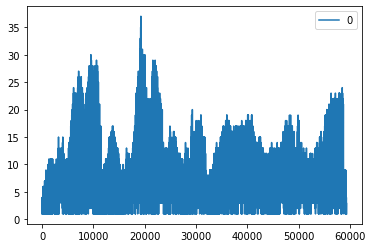

In [351]:
results = [p.waiting_time for 
               p in model.referrals if not p.waiting_time is None]

pd.DataFrame(results).plot()

In [348]:
args.bookings.head(20)

,clinic_1,clinic_2,clinic_3,clinic_4,clinic_5,clinic_6,clinic_7,clinic_8,clinic_9,clinic_10,clinic_11
day,,,,,,,,,,,
0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,1,1,1,1,0,0
2,0,0,0,1,0,1,1,0,1,0,0
3,2,1,3,3,0,4,0,2,3,8,0
4,3,1,6,2,1,4,2,1,4,10,0
5,2,1,2,3,1,2,3,2,3,6,0
6,2,1,6,3,1,5,3,1,2,10,0
7,1,1,7,3,2,5,4,2,5,11,1
8,3,1,6,3,1,5,3,2,5,10,1
